# How to use the Raytracing Algorithm 

In this tutorial we will use the _ASORA_ ray-tracing algorithm of pyC$^2$Ray as a stand alone. In principle, this algorithm can be used for any problem for 

The main assumption on the Radiative Transfer equation is:
$$ \hat{\vec{n}}\,\nabla I_\nu = -\kappa^{abs}_\nu\,I_\nu$$
where, $\hat{\vec{n}}$ is the unit vector pointing in the propagation direction and $\kappa^{abs}_\nu$ is the absorption coefficient. The solution leads to:

$$I_\nu(r) = I_\nu(r_0)\,e^{-\tau_\nu(r, r_0)}$$

From this assumption, we calculate the photoionization rate (number of photons per second aborbed by the medium) for a region at a given distance $r$ from the source.

$$\Gamma(r) = \frac{1}{4\pi\,r^2}\int_{\nu_0} \frac{L_\nu\,\sigma_\nu}{h\nu} \,e^{-\tau_\nu(r, r_0)}\,d\nu$$

In the case of pyC$^2$Ray, we consider the photoionization cross-section of hydrogen $\sigma_\nu$ is maximal at $\nu_0$ (and of course zero below), and then decreases approximately as a power-law. These quantities can be changed for any elements.

Here, we show a simple implementation on how to use it:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as cst

## Create $\Gamma(\tau)$ Tables
Here we import the pyc2ray package but it's only to be able to calculate the table of the $\Gamma$ VS $\tau$ that is later copied onto the GPU device. The reason to calculate a table is to avoid calculating (repeadetely) the same integrals at each iteration (for multiple time step).

In principle, this table can be choosed freely if you know the cross section and the Spectral Energy Distribution (SED) of the ionining source. In pyC$^2$Ray, we use a black body spectra and we consider only hydrogen.

In [2]:
import pyc2ray as pc2r

# HI cross section at its ionzing frequency (weighted by freq_factor)
sigma_HI_at_ion_freq = np.float64(6.30e-18)

# min and max frequency of the integral
freq_min, freq_max = (13.598*u.eV/cst.h).to('Hz').value, (54.416*u.eV/cst.h).to('Hz').value

# calculate the table
minlogtau, maxlogtau, NumTau = -20.0, 4.0, 20000
tau, dlogtau = pc2r.make_tau_table(minlogtau, maxlogtau, NumTau)

radsource = pc2r.radiation.BlackBodySource(1e5, False, freq_min, sigma_HI_at_ion_freq)
photo_thin_table, photo_thick_table = radsource.make_photo_table(tau, freq_min, freq_max, 1e48)

2024-09-30 15:53:39.088396: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 15:53:39.115357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 15:53:39.115379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 15:53:39.116166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 15:53:39.120886: I tensorflow/core/platform/cpu_feature_guar

If the table is define, then we only need to laod the _ASORA_ compiled source file:

In [3]:
from pyc2ray.lib import libasora as asora

Define variables by the raytracing:

In [4]:
boxsize, N = 50.*u.pc, 200
dr = (boxsize/N).cgs.value

# number of sources done in parallel on the GPU
source_batch_size = 8

# max distance (in pixel size) that the raytracing is computed
r_RT = 15.0

# allocate GPU memory for the grid and sources batch size
asora.device_init(N, source_batch_size)

# allocate tables to GPU device
asora.photo_table_to_device(photo_thin_table, photo_thick_table, NumTau)

GPU Device 0: "NVIDIA RTX A1000 6GB Laptop GPU" with compute capability 8.6
Succesfully allocated 704 Mb of device memory for grid of size N = 200, with source batch size 8


define density and other fields for the computation

In [5]:
coldensh_out = np.ravel(np.zeros((N, N, N), dtype='float64'))
phi_ion = np.ravel(np.zeros((N, N, N), dtype='float64')) # in ^-1
ndens = np.ravel(1e-3 * np.ones((N, N, N))).astype('float64',copy=True) # g/cm^3
xHII = np.ravel(1e-4 * np.ones((N, N, N))).astype('float64',copy=True)

# copy density field to GPU device
asora.density_to_device(ndens, N)

Define the sources position and flux.

In [6]:
nsrc = 1000

# efficiency factor (converting mass to photons)
f_gamma, t_s = 100., (3.*u.Myr).cgs.value

# fix random seed
np.random.seed(918)

# define some random sources
srcpos = np.random.randint(low=0, high=N, size=(3, nsrc))
normflux = f_gamma*np.random.uniform(low=1e10, high=1e14, size=nsrc)/1e48

# format the sources conform to the C++ module
srcpos_flat = np.ravel(srcpos.astype('int32', copy=True))
normflux_flat = normflux.astype('float64', copy=True)

# copy source list to GPU device
asora.source_data_to_device(srcpos_flat, normflux_flat, nsrc)

## Run _ASORA_ raytracing
Here you call the _ASORA_ algorithm and do the raytracing for all the source:

In [7]:
%%time
asora.do_all_sources(r_RT, coldensh_out, sigma_HI_at_ion_freq, dr, ndens, xHII, phi_ion, nsrc, N, minlogtau, dlogtau, NumTau)

CPU times: user 556 ms, sys: 39.7 ms, total: 596 ms
Wall time: 589 ms


Generally, the raytracing step is inlcude in a loop for multiple time-step, followed by an algorithm that solve the chemistry equation (in our case for neutral hydrogen). This step update the hydrogen density field that is used in the next time-step, as in the case of pyC$^2$Ray.

Here, we plot the hydrogen photoionization rate (left) and the corresponding column density (right).

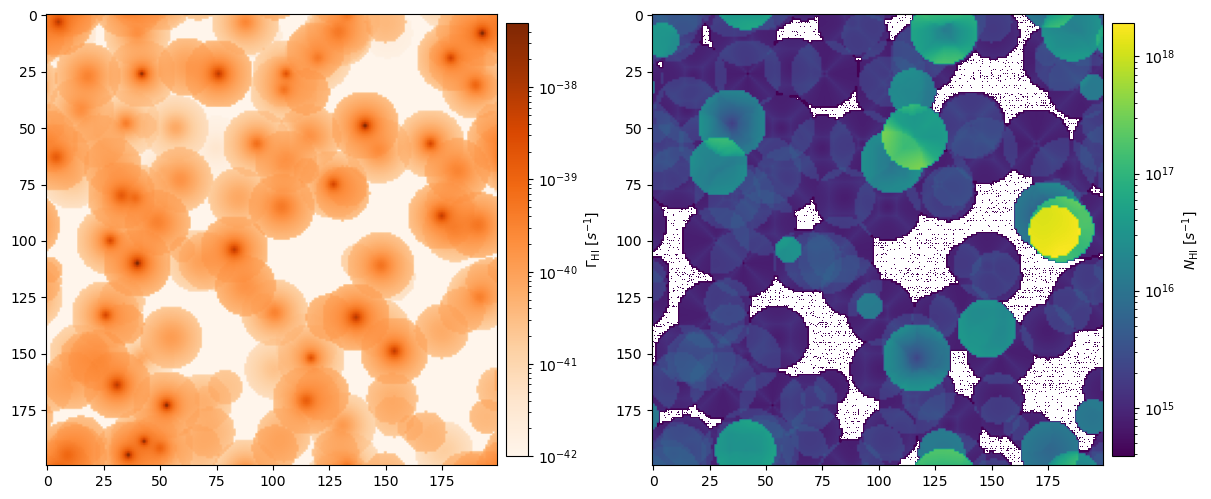

In [8]:
fig, axs = plt.subplots(figsize=(12, 8), nrows=1, ncols=2, constrained_layout=True)

phi = phi_ion.reshape(N,N,N)
im = axs[0].imshow(phi[...,100]+1e-42, norm='log', cmap='Oranges')
plt.colorbar(im, ax=axs[0], label=r'$\Gamma_\mathrm{HI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)

coldensh = coldensh_out.reshape(N,N,N)
im = axs[1].imshow(coldensh[...,100], norm='log', cmap='viridis')
plt.colorbar(im, ax=axs[1], label=r'$N_\mathrm{HI}$ [$s^{-1}$]', pad=0.02, fraction=0.048)

When you are finish, delocate the GPU device and free memory.

In [10]:
asora.device_close()